In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [7]:
class Autoencoder(object):
    def __init__(self, encoder, decoder, n_input, n_z, activation, final_activation=tf.nn.sigmoid,\
                 learning_rate=0.01, batch_size = 100):
        self.encoder = encoder
        self.decoder = decoder
        self.x = tf.placeholder(tf.float32, [None, n_input])
        self.activation = activation
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_input = n_input
        self.n_z = n_z
        self.out_act = final_activation
        
        self._create_network()
        self._create_loss()
        
        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _init_weights(self):
        self.encoder_weights = []
        self.encoder_bias = []
        Mi = self.n_input
        for Mo in self.encoder:
            self.encoder_weights.append(tf.Variable(xavier_init(Mi, Mo)))
            self.encoder_bias.append(tf.Variable(tf.zeros([Mo], tf.float32)))
            Mi=Mo
        self.encoder_weights_mu = tf.Variable(xavier_init(Mo, self.n_z))
        self.encoder_weights_sigma = tf.Variable(xavier_init(Mo, self.n_z))
        self.encoder_bias_mu = tf.Variable(tf.zeros([self.n_z], tf.float32))
        self.encoder_bias_sigma = tf.Variable(tf.zeros([self.n_z], tf.float32))
        
        self.decoder_weights = []
        self.decoder_bias = []
        Mi = self.n_z
        for Mo in self.encoder:
            self.decoder_weights.append(tf.Variable(xavier_init(Mi, Mo)))
            self.decoder_bias.append(tf.Variable(tf.zeros([Mo], tf.float32)))
            Mi=Mo
        self.decoder_weights_mu = tf.Variable(xavier_init(Mo, self.n_input))
        self.decoder_weights_sigma = tf.Variable(xavier_init(Mo, self.n_input))
        self.decoder_bias_mu = tf.Variable(tf.zeros([self.n_input], tf.float32))
        self.decoder_bias_sigma = tf.Variable(tf.zeros([self.n_input], tf.float32))

    def _create_network(self):
        self._init_weights()
        self.z_mean, self.z_log_sigma = self._create_encoder()
        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1, 
                               dtype=tf.float32)
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma)), eps))
        self.x_reconstruct = self._create_decoder()
        
    def _create_encoder(self):
        x_in = self.x
        for i in range(len(self.encoder)):
            x_in = self.activation(tf.add(tf.matmul(x_in, self.encoder_weights[i]), self.encoder_bias[i]))
        z_mean = tf.add(tf.matmul(x_in, self.encoder_weights_mu), self.encoder_bias_mu)
        z_sigma = tf.add(tf.matmul(x_in, self.encoder_weights_sigma), self.encoder_bias_sigma)
        return z_mean, z_sigma
    
    def _create_decoder(self):
        x_out = self.z
        for i in range(len(self.decoder)):
            x_out = self.activation(tf.add(tf.matmul(x_out, self.decoder_weights[i]), self.decoder_bias[i]))
        x_recon_mean = self.out_act(tf.add(tf.matmul(x_out, self.decoder_weights_mu), self.decoder_bias_mu))
        return x_recon_mean
    
    def _create_loss(self):
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstruct)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstruct),1)
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstruct, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstruct, 
                             feed_dict={self.x: X})

In [8]:
def train(encoder, decoder, n_input, n_z, activation, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = Autoencoder(encoder, decoder, n_input, n_z, activation, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [9]:
nz = 20
n_input = 784
vae = train([500,500], [500,500], n_input, nz, activation=tf.nn.softplus, training_epochs=51)

x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

('Epoch:', '0001', 'cost=', '180.790036288')
('Epoch:', '0006', 'cost=', '109.482635221')
('Epoch:', '0011', 'cost=', '104.331492448')
('Epoch:', '0016', 'cost=', '101.684003338')
('Epoch:', '0021', 'cost=', '100.109390287')
('Epoch:', '0026', 'cost=', '99.097812611')
('Epoch:', '0031', 'cost=', '98.393969560')
('Epoch:', '0036', 'cost=', '97.694267342')
('Epoch:', '0041', 'cost=', '97.193200226')
('Epoch:', '0046', 'cost=', '96.724637867')
('Epoch:', '0051', 'cost=', '96.369198858')


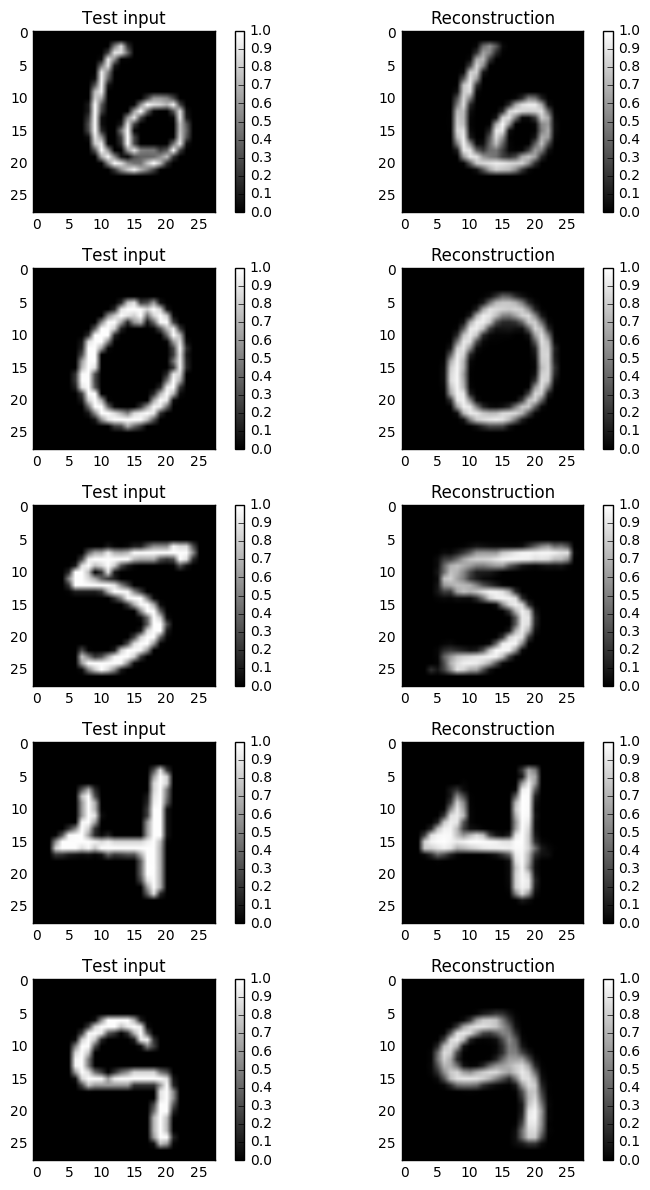

In [10]:
plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()